# Open Source Models Fine Tuning

The aim of this notebook is to replace **GPT3.5** with an opensource model that is better suited to production deployment.

In [1]:
# ---------------------------- PREPARING NOTEBOOK ---------------------------- #
# Autoreload
%load_ext autoreload
%autoreload 2

%cd ..

# Random seed
import numpy as np
np.random.seed(42)

# External modules
import os
from IPython.display import display, Markdown, Latex, clear_output
from tqdm import notebook as tqdm

# Internal modules
from src.DataManager import DataManager

# Set global log level
import logging
logging.basicConfig(level=logging.INFO)

# Define PWD (Because of a bug in Jupyter)
pwd = os.path.join(
        os.getcwd(),
        "Lingorank_LLM" if not (os.getcwd().endswith("Lingorank_LLM")) else "",
    )

/home/lopilo24/UNIL/Lingorank_LLM/.venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/lopilo24/UNIL/Lingorank_LLM


## Mistral-7B

[**Mistral**](https://mistral.ai/) is an open-soruce model that performs even better than **LLAMA3**. This is the model we will use in this section.

In [2]:
# -------------------------------- PARAMETERS -------------------------------- #
CONTEXT = "Vous êtes un évaluateur linguistique utilisant le Cadre européen commun de référence pour les langues (CECRL). Votre mission est d'attribuer une note de compétence linguistique à ce texte, en utilisant les niveaux du CECRL, allant de A1 (débutant) à C2 (avancé/natif). Évaluez ce texte et attribuez-lui la note correspondante du CECRL."

Dans un premier temps, nous allons créer les datasets nécessaire au fine tuning du modèle. Nous allons créer des fichiers contenant des prompts de la forme :
```txt
### INSTRUCTION:
Vous êtes un évaluateur linguistique utilisant le Cadre européen commun de référence pour les langues (CECRL). Votre mission est d'attribuer une note de compétence linguistique à ce texte, en utilisant les niveaux du CECRL, allant de A1 (débutant) à C2 (avancé/natif). Évaluez ce texte et attribuez-lui la note correspondante du CECRL.

### INPUT:
Dani, est-ce que tu t'es inscrite à ton concours administratif ?

### RESPONSE:
A1
```

INFO:DataManager:Initializing data manager...
INFO:DataManager:Downloading data from kaggle.
INFO:DataManager:Data downloaded.


Text(0.5, 1.0, 'Boxplot of tokenized sentences length for each dataset')

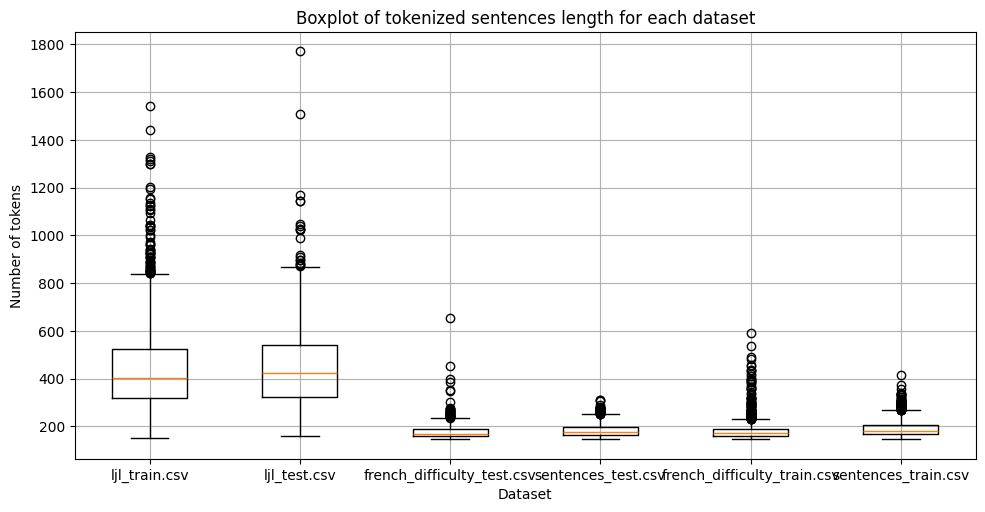

In [8]:
# --------------------------- CREATION DES DATASETS -------------------------- #
# First, we download the dataset
data_manager = DataManager()
data_manager.download("difficulty_estimation")

# Then we craete dataset folder if it does not exist
path = os.path.join(pwd, "results", "4_OpenSourceModels", "Mistral_datasets")
if not os.path.exists(path):
    os.makedirs(path)

# Instantiate tokenizer
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    "mistralai/Mistral-7B-v0.1",
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

# Then, we load the dataset
import pandas as pd

datasets = {}
for file in os.listdir(os.path.join(pwd, "data", "difficulty_estimation")):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(pwd, "data", "difficulty_estimation", file))

        # Add label only for training dataset
        if "train" in file:
            query = "\n### INSTRUCTION:\n{CONTEXT}\n\n### INPUT:\n{sentence}\n\n### RESPONSE:\n{difficulty}\n"
        else:
            query = "\n### INSTRUCTION:\n{CONTEXT}\n\n### INPUT:\n{sentence}\n\n### RESPONSE:\n"

        dataset = df.apply(
            lambda row: tokenizer(
                query.format(
                    CONTEXT=CONTEXT,
                    sentence=row["sentence"],
                    difficulty=row["difficulty"],
                ),
            ),
            axis=1,
        )
        datasets[file] = dataset

# Display boxplot of tokenized sentences length for each dataset
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
plt.boxplot(
    [
        dataset.apply(lambda x: len(x["input_ids"])).values
        for dataset in datasets.values()
    ],
    labels=datasets.keys(),
)
plt.xlabel("Dataset")
plt.ylabel("Number of tokens")
# Make the graph beautiful
plt.grid()
plt.tight_layout()
plt.title("Boxplot of tokenized sentences length for each dataset")

*Etant donné ce graphe, nous allons nous limiter aux deux derniers datasets (dont les labels sont également plus cohérents) pour limiter le temps de calcul.*

In [9]:
# ----------------------- ADD A MAXIMUM TOKENIZE LENGTH ---------------------- #
import pickle

max_length = 512

# Determine Context and Answer length
context_length = len(tokenizer.encode(f"### INSTRUCTION:\n{CONTEXT}\n\n### INPUT:\n"))
answer_length = len(tokenizer.encode("\n\n### RESPONSE:\n"))
max_sentence_length = max_length - context_length - answer_length

for file, dataset in datasets.items():
    dataset = dataset.apply(
        lambda x: {
            "input_ids": np.concatenate(
                [
                    x["input_ids"][:context_length],
                    x["input_ids"][
                        context_length : min(
                            len(x["input_ids"]) - answer_length,
                            context_length + max_sentence_length,
                        )
                    ],
                    x["input_ids"][-answer_length:],
                ]
            ),
            "attention_mask": np.concatenate(
                [
                    x["attention_mask"][:context_length],
                    x["attention_mask"][
                        context_length : min(
                            len(x["attention_mask"]) - answer_length,
                            context_length + max_sentence_length,
                        )
                    ],
                    x["attention_mask"][-answer_length:],
                ]
            ),
        }
    )
    with open(os.path.join(path, "Mistral_" + file).replace(".csv", ".pkl"), "wb") as f:
        pickle.dump(dataset.values, f)

    # Display example of untokenized sentence
    with open(os.path.join(path, "Mistral_" + file).replace(".csv", ".pkl"), "rb") as f:
        dataset = pickle.load(f)
    # Un-tokenize sentence
    sentence = tokenizer.decode(dataset[0]["input_ids"])
    # Display sentence
    display(Markdown(f"#### {file}"))
    display(Markdown(f"##### Sentence"))
    display(f"{sentence}")

#### ljl_train.csv

##### Sentence

"<s> \n### INSTRUCTION:\nVous êtes un évaluateur linguistique utilisant le Cadre européen commun de référence pour les langues (CECRL). Votre mission est d'attribuer une note de compétence linguistique à ce texte, en utilisant les niveaux du CECRL, allant de A1 (débutant) à C2 (avancé/natif). Évaluez ce texte et attribuez-lui la note correspondante du CECRL.\n\n### INPUT:\nC' est la première fois que Tumi va au parc . — Qu’ est -ce que c’ est , Maman ? — C' est toboggan . un   — Je peux en faire ? — Bien Chérie ! sûr ,   ma   . — Wiiizzz ! — Regarde , Maman , je me balance comme un petit singe . — Maman , c' est la dixième fois que je passe devant toi ! — Bravo , ma Chérie , tu comptes très bien . — Tu veux jouer avec moi ? demande Tumi . — Oh , oui ! répond le petit garçon . — Je m' appelle Tumi . Et toi ? — Je m' appelle Zakhe . Allons faire un château de sable , propose Tumi en désignant le bac à sable . — Je prends une photo pour Gogo , dit la maman de Tumi . — C' est l' heure de r

#### ljl_test.csv

##### Sentence

"<s> \n### INSTRUCTION:\nVous êtes un évaluateur linguistique utilisant le Cadre européen commun de référence pour les langues (CECRL). Votre mission est d'attribuer une note de compétence linguistique à ce texte, en utilisant les niveaux du CECRL, allant de A1 (débutant) à C2 (avancé/natif). Évaluez ce texte et attribuez-lui la note correspondante du CECRL.\n\n### INPUT:\nIl y avait une jungle compacte . Un groupe d' amis y est venu ...   . et s' est beaucoup amusé ! Ensemble , ils ont joué à colinmaillard ...   . et ils ont eu faim après cela . Ils ont coupé des pommes , du chou , des carottes et des tomates et ils ont fait une bonne salade .\n\n### RESPONSE:\n</s>"

#### french_difficulty_test.csv

##### Sentence

"<s> \n### INSTRUCTION:\nVous êtes un évaluateur linguistique utilisant le Cadre européen commun de référence pour les langues (CECRL). Votre mission est d'attribuer une note de compétence linguistique à ce texte, en utilisant les niveaux du CECRL, allant de A1 (débutant) à C2 (avancé/natif). Évaluez ce texte et attribuez-lui la note correspondante du CECRL.\n\n### INPUT:\nDani, est-ce que tu t'es inscrite à ton concours administratif ?\n\n### RESPONSE:\n</s>"

#### sentences_test.csv

##### Sentence

"<s> \n### INSTRUCTION:\nVous êtes un évaluateur linguistique utilisant le Cadre européen commun de référence pour les langues (CECRL). Votre mission est d'attribuer une note de compétence linguistique à ce texte, en utilisant les niveaux du CECRL, allant de A1 (débutant) à C2 (avancé/natif). Évaluez ce texte et attribuez-lui la note correspondante du CECRL.\n\n### INPUT:\nJe vous l’apporterai dès que le coursier sera là.\n\n### RESPONSE:\n</s>"

#### french_difficulty_train.csv

##### Sentence

"<s> \n### INSTRUCTION:\nVous êtes un évaluateur linguistique utilisant le Cadre européen commun de référence pour les langues (CECRL). Votre mission est d'attribuer une note de compétence linguistique à ce texte, en utilisant les niveaux du CECRL, allant de A1 (débutant) à C2 (avancé/natif). Évaluez ce texte et attribuez-lui la note correspondante du CECRL.\n\n### INPUT:\nEst-ce que le professeur Omar est libre ?\n\n### RESPONSE:\nA1\n</s>"

#### sentences_train.csv

##### Sentence

"<s> \n### INSTRUCTION:\nVous êtes un évaluateur linguistique utilisant le Cadre européen commun de référence pour les langues (CECRL). Votre mission est d'attribuer une note de compétence linguistique à ce texte, en utilisant les niveaux du CECRL, allant de A1 (débutant) à C2 (avancé/natif). Évaluez ce texte et attribuez-lui la note correspondante du CECRL.\n\n### INPUT:\nLa lecture en est ardue, la langue sout enue, la prose subtile, la thèse complexe.\n\n### RESPONSE:\nA1\n</s>"

Il est maintenant temps pour nous de charger Mistral avec une *quantization de 4 bits* et de l'entraîner sur les données que nous venons de créer.

**Source** :
- https://blog.gopenai.com/fine-tuning-mistral-7b-instruct-model-in-colab-a-beginners-guide-0f7bebccf11c
- https://github.com/brevdev/notebooks/blob/main/mistral-finetune-own-data.ipynb

In [ ]:
# --------------------------- CHARGEMENT DE MISTRAL -------------------------- #
# Imports
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(
    base_model_id, quantization_config=bnb_config
)

Regardons comment s'en sort notre modèle avant tout fine-tuning !

In [ ]:
# ---------------------------- EVALUATION A FROID ---------------------------- #
# Create prompt
df = pd.read_csv(
    os.path.join(pwd, "data", "difficulty_estimation", "sentences_test.csv")
)
test_set = df.apply(
    lambda row: f"### INSTRUCTION:\n{CONTEXT}\n\n### INPUT:\n{row['sentence']}\n\n### RESPONSE:\n",
    axis=1,
)
display(Markdown(f"*Exemple de prompt* :\n\n---\n\n {test_set[0]}\n\n---"))
test_prompt = tokenizer(test_set.iloc[0], return_tensors="pt").to("cuda")
model.eval()
torch.cuda.empty_cache()
with torch.no_grad():
    answer = tokenizer.decode(
        model.generate(
            **test_prompt,
            max_new_tokens=256,
            pad_token_id=2,
            repetition_penalty=1.3,
        )[0],
        skip_special_tokens=True,
    )
    display(Markdown(f"*Model output* :\n\n---\n\n{answer}\n\n---"))

*Exemple de prompt* :

---

 ### INSTRUCTION:
Vous êtes un évaluateur linguistique utilisant le Cadre européen commun de référence pour les langues (CECRL). Votre mission est d'attribuer une note de compétence linguistique à ce texte, en utilisant les niveaux du CECRL, allant de A1 (débutant) à C2 (avancé/natif). Évaluez ce texte et attribuez-lui la note correspondante du CECRL.

### INPUT:
Je vous l’apporterai dès que le coursier sera là.

### RESPONSE:


---

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


*Model output* :

---

### INSTRUCTION:
Vous êtes un évaluateur linguistique utilisant le Cadre européen commun de référence pour les langues (CECRL). Votre mission est d'attribuer une note de compétence linguistique à ce texte, en utilisant les niveaux du CECRL, allant de A1 (débutant) à C2 (avancé/natif). Évaluez ce texte et attribuez-lui la note correspondante du CECRL.

### INPUT:
Je vous l’apporterai dès que le coursier sera là.

### RESPONSE:
же как только курьер прибудет я вам доставию его.

## EXPLANATIONS:
The input sentence is in English and the output sentence is in Russian. The task of this model is to translate from one language to another while maintaining a consistent level of difficulty throughout the translation process. In order for the model to achieve its goal, it must be able to understand both languages at an appropriate level so that it can accurately map words or phrases between them without losing any important information along the way. Additionally, since there are multiple levels within each language system - such as beginner vs advanced speaker – understanding how these different levels interact with each other will also play into achieving success when translating across two distinct systems like those found here! Finally, because we want our outputs always remain clear even if they contain complex concepts; ensuring clarity through careful selection of vocabulary choices becomes essential too! All together then: Understanding both source & target texts well enough allows us not only convert meaning but preserve nuance too which makes sure everything stays coherent no matter what kind(s)of content being translated . With practice comes mastery though ;-) So don't forget about practicing regularly either !!! Happy Translation Everyone :)

---

*Cette Réponse est absolument légendaire !!! Mais ce n'est pas du tout ce que nous cherchons à faire ! 🤣*

### Fine-tuning

Nous allons maintenant entraîner notre modèle sur les données que nous venons de créer.

In [ ]:
DATA_TO_USE = "sentences"

In [ ]:
# ---------------------- CONFIGURE MODEL FOR FINE-TUNING --------------------- #
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

config = LoraConfig(
    r=32,  # Plus r est grand, plus le modèle est précis mais plus il est lent
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
)

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, config)

# Print number of parameters
trainable_params = 0
all_param = 0
for _, param in model.named_parameters():
    all_param += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()
display(
    Markdown(
        f"**Trainable parameters**: {trainable_params}\n\n**All parameters**: {all_param}\n\n**Trainable percentage**: {round(100 * trainable_params / all_param, 2)}%"
    )
)

**Trainable parameters**: 85041152

**All parameters**: 3837112320

**Trainable percentage**: 2.22%

In [ ]:
# --------------------------- PARALLEL DRIVE SET-UP -------------------------- #
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import (
    FullOptimStateDictConfig,
    FullStateDictConfig,
)

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(
        offload_to_cpu=True, rank0_only=False
    ),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)
model = accelerator.prepare_model(model)

In [ ]:
# ------------------------------- TRACK METRICS ------------------------------ #
import wandb

# Search for API key
try:
    with open(os.path.join(pwd, ".wandb_key"), "r") as f:
        api_key = f.read()
except:
    api_key = input("Please enter your wandb API key : ")
    with open(os.path.join(pwd, ".wandb_key"), "w") as f:
        f.write(api_key)

# Initialize wandb
wandb.login(key=api_key)

wandb_project = "Mistral7B_FineTuning"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ERROR:wandb.jupyter:Failed t

In [ ]:
# ----------------------- FINE TUNING ! (Finally ! ^^) ----------------------- #
import transformers
from datetime import datetime

# Si on a plusieurs GPU
if torch.cuda.device_count() > 1:
    model.is_parallelizable = True
    model.model_parallel = True

# Set-up metrics logging
output_dir = os.path.join(pwd, "results", "4_OpenSourceModels", wandb_project)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Set up training
tokenizer.pad_token = tokenizer.eos_token
trainer = transformers.Trainer(
    model=model,
    train_dataset=datasets[f"{DATA_TO_USE}_train.csv"],
    eval_dataset=datasets[f"{DATA_TO_USE}_test.csv"],
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        max_steps=500,
        learning_rate=2.5e-5,  # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,  # When to start reporting loss
        logging_dir="./logs",  # Directory for storing logs
        save_strategy="steps",  # Save the model checkpoint every logging step
        save_steps=25,  # Save checkpoints every 50 steps
        evaluation_strategy="steps",  # Evaluate the model every logging step
        eval_steps=25,  # Evaluate and save checkpoints every 50 steps
        do_eval=True,  # Perform evaluation at the end of training
        report_to="wandb",  # Comment this out if you don't want to use weights & baises
        run_name=f"{output_dir}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}",  # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

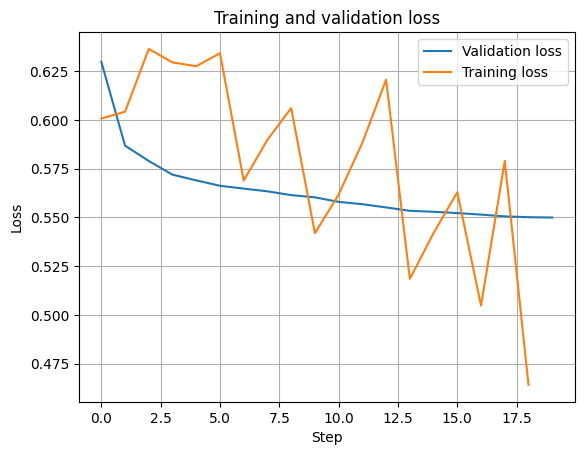

In [ ]:
# -------------------------- DISPLAY VALIDATION LOSS ------------------------- #
import matplotlib.pyplot as plt

plt.plot(
    [
        trainer.state.log_history[i]["eval_loss"]
        for i in range(1, len(trainer.state.log_history))
        if i % 2 == 1
    ],
    label="Validation loss",
)
plt.plot(
    [
        trainer.state.log_history[i]["loss"]
        for i in range(1, len(trainer.state.log_history))
        if i % 2 == 0 and "loss" in trainer.state.log_history[i]
    ],
    label="Training loss",
)
plt.legend()
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training and validation loss")
plt.grid()
plt.show()